In [2]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

## 1. data exploration

In [3]:
#Read in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
#Look at some statistics of training data
print "Number of training data: %d" %len(train_data_raw)
print "Ratio of duplicate question pairs:%f %%" %round(train_data_raw["is_duplicate"].mean()*100,2)
qids=pd.Series(train_data_raw['qid1'].tolist() + train_data_raw['qid2'].tolist())
print "Total number of questions: %d" %len(np.unique(qids))
print "Number of questions appearing multiple times: %d" %np.sum(qids.value_counts()>1)

Number of training data: 404290
Ratio of duplicate question pairs:36.920000 %
Total number of questions: 537933
Number of questions appearing multiple times: 111780


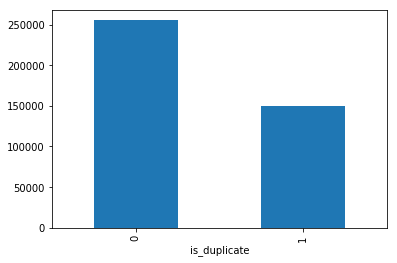

In [4]:
train_data_raw.groupby('is_duplicate')['id'].count().plot.bar()
#There are 37% duplicate questions in the training set. 
#We also see that there are many identical questions in the data set.

In [5]:
#Read in test data and look at the first 5 rows
test_data_raw=pd.read_csv("test.csv")
print "Number of testing data: %d" %len(test_data_raw)
test_data_raw.head(5)

Number of testing data: 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


(-0.5, 1279.5, 979.5, -0.5)

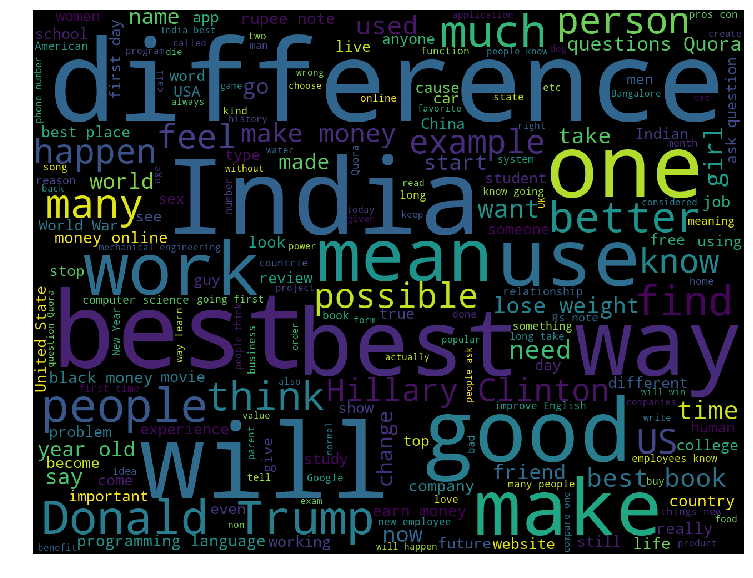

In [6]:
#Check out the most common words in word cloud graph from training data.
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2=WordCloud(width=1280,height=900).generate("".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(cloud1)
plt.axis("off")

(-0.5, 1279.5, 899.5, -0.5)

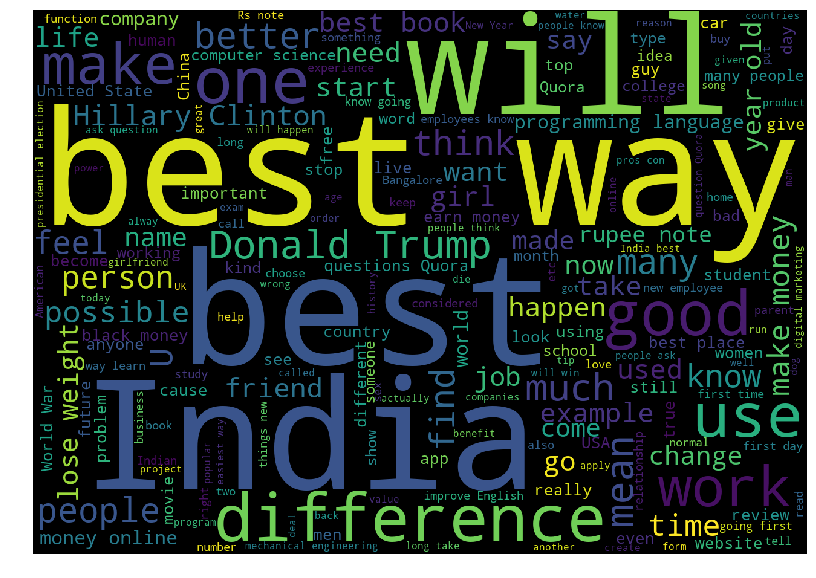

In [22]:
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')
#Two word clouds generated from question 1 and question 2 
# show that there are a few duplicate most common words in them.

## 2. data processing

In [6]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [7]:
#Combine all questions into corpus for TFIDF analysis
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)

In [8]:
words=(" ".join(train_questions)).lower().split()
counts = Counter(words)

#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R
eps = 5000 
weights = {word: get_weight(count) for word, count in counts.items()}

In [10]:
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
# 把是0的放到很后面

Most common words:  [('the', 2.623060902228028e-06), ('what', 3.164927538983995e-06), ('is', 3.651647440742891e-06), ('how', 4.463907079310237e-06), ('i', 4.5832664940302954e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100834594172483e-06), ('do', 6.260956674179815e-06)]


In [9]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [10]:
#Construct features for training data: character(字母) length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda x: len(str(x).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1) # 如果这里不写axis就会按照行来找question1
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm,axis=1,raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66,57.0,14,12,0.434783,0.400611
1,51,88.0,8,13,0.200000,0.193056
2,73,59.0,14,10,0.166667,0.149204
3,50,65.0,11,9,0.000000,0.000000
4,76,39.0,13,7,0.100000,0.009949


In [11]:
#Check if there's NaN values in the data. If yes, replace them.
train_data.isnull().sum()

q1chrlen       0
q2chrlen       2
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [12]:
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [13]:
#Process test data to have the same features as training data
test_data=pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN if any
np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

## feature visualization and normalization

Text(0,0.5,u'Probability')

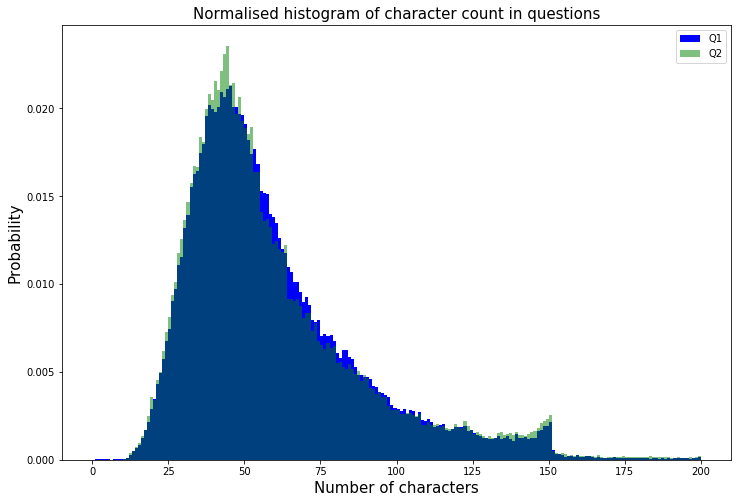

In [16]:
#Get some visual on character count
plt.figure(figsize=(12,8))
plt.hist(train_data['q1chrlen'],bins=200,range=[0,200],color='blue',normed=True,label='Q1')
plt.hist(train_data['q2chrlen'],bins=200,range=[0,200],color='green',alpha=0.5,normed=True,label='Q2')
plt.title('Normalised histogram of character count in questions',fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
# Looks like most questions have about 40-50 characters in them.

Text(0,0.5,u'Probability')

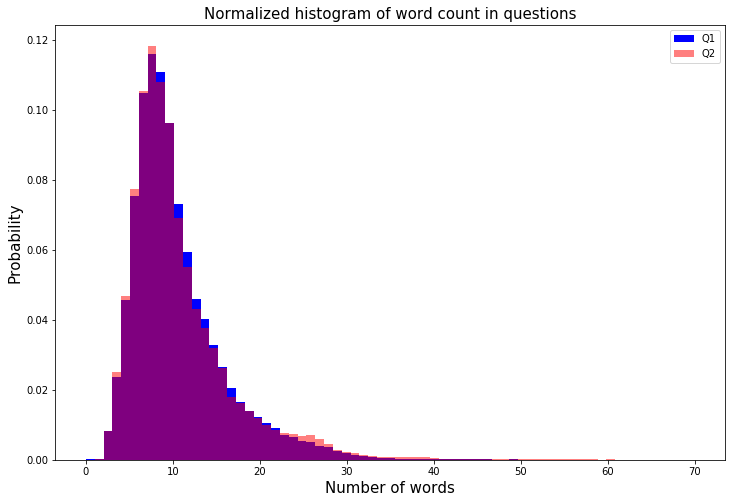

In [101]:
#Get some visual on word count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
#Looks like most questions have about 10 words in them.

Text(0.5,0,u'word_share_ratio')

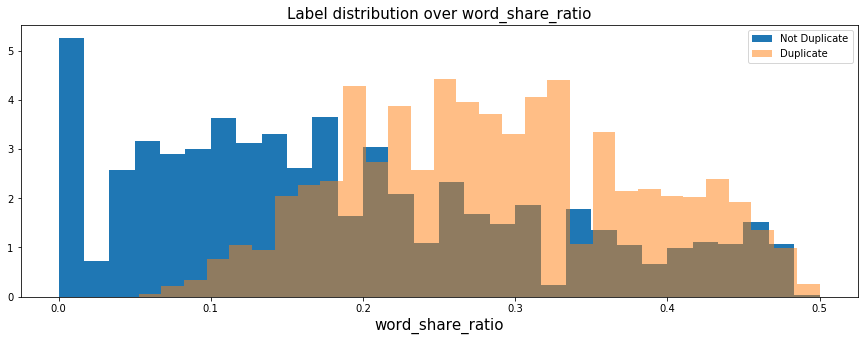

In [105]:
#Get some visual on word share
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

Text(0.5,0,u'TFIDF_share')

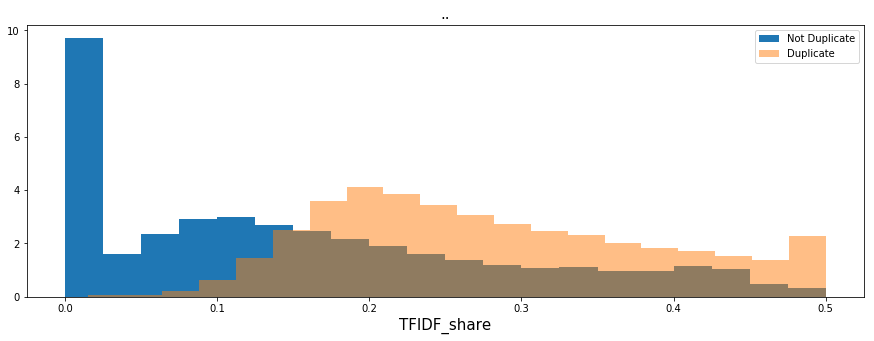

In [107]:
#Get some visual on TFIDF word share
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

In [108]:
#As one would expect, the word share ratio is higher for duplicate question pairs.
#Now we normalized all features for better machine learning accuracy.

In [14]:
#Normalized feature values
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [15]:
#Split training data to train and validation data sets
label = train_data_raw['is_duplicate']
X_train,X_valid,y_train,y_valid = train_test_split(train_data,label,test_size=0.2,
                                                   random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, 
                                                                    test_size=0.2, random_state=10)


## 4. use random forest as benchmark model (0.55)

In [111]:
#Benchmark model : random forest
rfc=RandomForestClassifier(max_depth=5,random_state=0)
rfc.fit(X_train_scaled,y_train)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc

Random Forest (Benchmark model) has accuracy: 0.721


In [112]:
#Test submission for Kaggle competition
prediction = rfc.predict_proba(test_data_scaled)
#sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
#sub.to_csv('rfc_submission.csv', index=False)


## 5. Compare Supervised Learning Models

#### 1-logistic regression (0.61)

In [113]:
#Model 1: Logistic regression model
#Use GridSearch cross validation to find best parameter
lr=LogisticRegression(random_state=10)
grid={'C':[1e-6, 1e-3, 1e0, 1e3, 1e6],
     'penalty':['l1', 'l2']}
cv=GridSearchCV(lr,grid,scoring='neg_log_loss',verbose=True)
cv.fit(X_train_scaled,y_train)
print cv.best_params_
score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "Logistic regression model accuracy: %.3f" %score_lr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.9s finished


{'penalty': 'l2', 'C': 1000.0}
Logistic regression model accuracy: 0.669


In [114]:
#Test submission for Kaggle competition
# lr = LogisticRegression(C = 1000, penalty = 'l2', random_state=10)
# lr.fit(X_train_scaled, y_train)
# prediction = lr.predict_proba(test_data_scaled)
# prediction = lr.predict_proba(test_data_scaled)
# sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
# sub.to_csv('lr_submission.csv', index=False)

#### 2.Decision Tree (13.44)

In [115]:
#Model 2: Decision tree 
dt=DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(X_train_scaled, y_train)
score_dt = dt.score(X_valid_scaled, y_valid)
print "Decision tree model accuracy: %.3f" %score_dt

Decision tree model accuracy: 0.695


In [116]:
#Test submission for Kaggle competition
'''
prediction = dt.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('dt_submission.csv', index=False)

'''
# Because decision tree prediction is not really a probability, the testing score is pretty low.

"\nprediction = dt.predict_proba(test_data_scaled)\nsub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})\nsub.to_csv('dt_submission.csv', index=False)\n\n"

#### 3. Support Vector Machine  (0.57)

In [19]:
#Model 3: SVM model
#Use GridSearch cross validation to find best parameter
svm=SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv=GridSearchCV(svm,grid,scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_svm = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "SVM model accuracy: %.3f" %score_svm

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/xuan/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 46.0min finished


{'kernel': 'sigmoid', 'C': 0.001}
SVM model accuracy: 0.492


In [20]:
#Test submission for Kaggle competition
svm = SVC(random_state=0, max_iter=1000, probability=True, kernel='sigmoid', C=0.001)
svm.fit(X_train_scaled, y_train)
prediction = svm.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('svm_submission.csv', index=False)
# prediction[:,1] 属于class1的概率，即是duplicate的概率

/Users/xuan/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


#### 4. K Nearest Neighbors （1.64）

In [25]:
#Model 4: K Nearest Neighbors
#Use grid search for best parameter
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "K Nearest Neighbor model accuracy: %.3f" %score_knn

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 10.7min finished


{'n_neighbors': 8, 'weights': 'uniform'}
K Nearest Neighbor model accuracy: 0.719


In [26]:
#Test submission for Kaggle competition
# knn = KNeighborsClassifier(n_neighbors = 8, weights = 'uniform')
# knn.fit(X_train_scaled, y_train)
# prediction = knn.predict_proba(test_data_scaled)
# sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
# sub.to_csv('knn_submission.csv', index=False)

#### 5. Multinomial Naive Bayes (0.53)

In [27]:
#Model 5: Naive Bayes model
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
print "Naive Bayes model accuracy: %.3f" %score_nb

Naive Bayes model accuracy: 0.633


In [28]:
#Test submission for Kaggle competition
# prediction = mnb.predict_proba(test_data)
# sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
# sub.to_csv('nb_submission.csv', index=False)

#### 6. XGboost (0.39)

In [37]:
#Model 6: XGBoost 
# paramters: http://blog.csdn.net/wzmsltw/article/details/50994481
params={}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_scaled, label=y_train)
d_valid = xgb.DMatrix(X_valid_scaled, label=y_valid)

# http://xgboost.readthedocs.io/en/latest/python/python_api.html
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_test = xgb.DMatrix(test_data_scaled)
p_test = bst.predict(d_test)


[0]	train-logloss:0.686721	valid-logloss:0.686709
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.634151	valid-logloss:0.63404
[20]	train-logloss:0.596905	valid-logloss:0.596762
[30]	train-logloss:0.569502	valid-logloss:0.569371
[40]	train-logloss:0.548966	valid-logloss:0.548845
[50]	train-logloss:0.533259	valid-logloss:0.533152
[60]	train-logloss:0.521116	valid-logloss:0.521021
[70]	train-logloss:0.511607	valid-logloss:0.511529
[80]	train-logloss:0.504034	valid-logloss:0.503967
[90]	train-logloss:0.498007	valid-logloss:0.497969
[100]	train-logloss:0.493212	valid-logloss:0.493196
[110]	train-logloss:0.489284	valid-logloss:0.489313
[120]	train-logloss:0.486026	valid-logloss:0.486087
[130]	train-logloss:0.483387	valid-logloss:0.483496
[140]	train-logloss:0.481188	valid-logloss:0.481337
[150]	train-logloss:0.479309	valid-logloss:0.479499
[160]	train-logloss:0.477704	

In [38]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': p_test})
sub.to_csv('xgb_submission.csv', index=False)

In [1]:
#Visualize the prediction
from matplotlib.pylab import rcParams
from xgboost import plot_tree
rcParams['figure.figsize'] = 120,100
plot_tree(bst)

NameError: name 'bst' is not defined

## 6. reinfinement

In [33]:
#Let's get TFIDF vector from each question 
Test_num = len(test_data_raw)
test_data_raw['qid1'] = pd.Series(range(2*Test_num)[1::2])
test_data_raw['qid2'] = pd.Series(range(2*Test_num+1)[2::2])
train_q1, train_q2 = train_data_raw[['qid1', 'question1']], train_data_raw[['qid2', 'question2']]
train_q1.columns = ['qid1', 'question']
train_q2.columns = ['qid2', 'question']
trainq = pd.concat((train_q1, train_q2), axis=0, ignore_index=True).fillna("")

test_q1, test_q2 = test_data_raw[['qid1', 'question1']], test_data_raw[['qid2', 'question2']]
test_q1.columns = ['qid1', 'question']
test_q2.columns = ['qid2', 'question']
testq = pd.concat((test_q1, test_q2), axis=0, ignore_index=True).fillna("")
#Combine train and test questions for our corpus
questionpairs=pd.concat((trainq,testq),axis=0,ignore_index=True).fillna("")


In [34]:
questionpairs.head()

,qid1,qid2,question
0,1,,What is the step by step guide to invest in sh...
1,3,,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,5,,How can I increase the speed of my internet co...
3,7,,Why am I mentally very lonely? How can I solve...
4,9,,"Which one dissolve in water quikly sugar, salt..."


In [38]:
#Set up TFIDF Vectorizer with max 10k features then fit our question corpus
tfidfv=TfidfVectorizer(max_features=10000)
matrixq=tfidfv.fit_transform(questionpairs['question'].values)

#Use Truncated SVD for dimension reduction on the TFIDF matrix
tsvd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=0)
tfidf_vec = tsvd.fit_transform(matrixq)
tfidf_vec = pd.DataFrame(tfidf_vec)

In [55]:
#Get length from train and test data
Train_num = len(train_data_raw)
Test_num = len(test_data_raw)

#Now separate training and testing data sets
vec_train = tfidf_vec[0:Train_num*2].reset_index(drop=True)
vec_test = tfidf_vec[Train_num*2:].reset_index(drop=True)

In [61]:
# Method: All all TFIDF vectors from question 1 and question 2 into feature columns
q1=vec_train[0:Train_num]
q2 = vec_train[Train_num:].reset_index(drop=True)
tfidfvec_train = pd.concat((q1,q2),axis = 1, ignore_index=True)

q2t = vec_test[Test_num:].reset_index(drop=True)
q1t = vec_test[0:Test_num]
tfidfvec_test = pd.concat((q1t,q2t),axis = 1, ignore_index=True)

In [62]:
#Add these TFIDF reduced vector "distance" as new features
label = train_data_raw['is_duplicate']
train_data_new = pd.concat((train_data, tfidfvec_train), axis=1)
test_data_new = pd.concat((test_data, tfidfvec_test), axis=1)

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data_new, label, test_size=0.2, random_state=10)
#Normalize data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
test_data_new_scaled=scaler.fit_transform(test_data_new)

In [79]:
#XGBoost 
# paramters: http://blog.csdn.net/wzmsltw/article/details/50994481
params={}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_scaled, label=y_train)
d_valid = xgb.DMatrix(X_valid_scaled, label=y_valid)

# http://xgboost.readthedocs.io/en/latest/python/python_api.html
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)


d_test = xgb.DMatrix(test_data_new_scaled)
p_test = bst.predict(d_test)


[0]	train-logloss:0.686707	valid-logloss:0.686708
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.633992	valid-logloss:0.634062
[20]	train-logloss:0.596447	valid-logloss:0.596568
[30]	train-logloss:0.568916	valid-logloss:0.56909
[40]	train-logloss:0.548194	valid-logloss:0.548455
[50]	train-logloss:0.532193	valid-logloss:0.532582
[60]	train-logloss:0.519553	valid-logloss:0.520047
[70]	train-logloss:0.509414	valid-logloss:0.510013
[80]	train-logloss:0.501221	valid-logloss:0.501921
[90]	train-logloss:0.494344	valid-logloss:0.495108
[100]	train-logloss:0.488926	valid-logloss:0.489777
[110]	train-logloss:0.484238	valid-logloss:0.485156
[120]	train-logloss:0.480417	valid-logloss:0.48139
[130]	train-logloss:0.477179	valid-logloss:0.478208
[140]	train-logloss:0.474306	valid-logloss:0.475413
[150]	train-logloss:0.471803	valid-logloss:0.472989
[160]	train-logloss:0.469561	v

In [66]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': p_test})
sub.to_csv('xgb_submission_new.csv', index=False)

NameError: name 'p_test' is not defined